In this notebook, we explore active learning when already having a set of experimentally determined TCR-APL library pairs. The question is: which APLs should we measure for a new TCR, to be able to predict the remaining ones with highest performance.

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tqdm import tqdm
from itertools import product

In [3]:
import json
import os
import random
import sys
sys.path.append('..')

from preprocessing import add_activation_thresholds, full_aa_features, get_aa_features 
from preprocessing import get_complete_dataset
                
from utils_al import train_classification_model, predict_classification_on_test, train_regression_model
from utils_al import predict_regression_on_test, evaluate_classification_models, evaluate_regression_models
from utils_al import get_aa_blosum, get_metrics_cls, get_metrics_reg

## Data Loading

In [4]:
BASE_EPITOPE = 'SIINFEKL'
NORMALIZATION = 'AS'
THRESHOLD = '46.9'

In [5]:
def load_data():
    data = get_complete_dataset()
    data = add_activation_thresholds(data)
    data = data[data['normalization'] == NORMALIZATION]
    data = data[data['threshold'] == THRESHOLD]
    data = data[data['is_educated'] == True]
    aa_features = get_aa_features()
    features_no_mutation = aa_features.loc[['-']]
    features_no_mutation.rename(index={'-': None}, inplace=True)
    aa_features = pd.concat([aa_features, features_no_mutation])
    features = full_aa_features(data, aa_features[['factors']])
    return data, features
data_full, features_full = load_data()

## Helper Functions

In [6]:
def train_classification_model(data, features, epitopes_train, seed):
    mask = data['epitope'].isin(epitopes_train)
    data_train = data[mask]
    feat_train = features[mask]
    y_train = data_train['is_activated']
    clf = RandomForestClassifier(n_estimators=1000, random_state=seed).fit(feat_train, y_train)
    return clf

In [7]:
def predict_classification_on_test(data, features, clf, epitopes_train):
    mask = ~data['epitope'].isin(epitopes_train)
    data_test = data[mask]
    feat_test = features[mask]
    
    y_test = data_test['is_activated']
    p_test = clf.predict_proba(feat_test)
    p_test = p_test[:, (1 if p_test.shape[1] == 2 else 0)]
    return p_test, y_test

In [8]:
def train_regression_model(data, features, epitopes_train, seed):
    mask = data['epitope'].isin(epitopes_train)
    data_train = data[mask]
    feat_train = features[mask]
    y_train = data_train['activation']
    reg = RandomForestRegressor(n_estimators=250, max_features='sqrt', criterion='mae', random_state=seed).fit(feat_train, y_train)
    return reg

In [9]:
def predict_regression_on_test(data, features, reg, epitopes_train):
    mask = ~data['epitope'].isin(epitopes_train)
    data_test = data[mask]
    feat_test = features[mask]
    
    y_test = data_test['activation']
    y_pred = reg.predict(feat_test)
    return y_pred, y_test

## Aquisition Functions

In [10]:
def add_random(data, features, epitopes_train, clf, reg, N):
    remaining_epitopes = data[~data['epitope'].isin(epitopes_train)]
    remaining_epitopes = remaining_epitopes['epitope']
    remaining_epitopes = remaining_epitopes.values
    new_epitopes = np.random.choice(remaining_epitopes, N, replace=False).tolist()
    return new_epitopes

In [11]:
def add_random_positionwise(data, features, epitopes_train, clf, reg, N):
    remaining_epitopes = data[~data['epitope'].isin(epitopes_train)]['epitope'].tolist()
    epitopes = {i: [BASE_EPITOPE[:i] + new_aa + BASE_EPITOPE[i+1:] 
                    for new_aa in 'GALMFWKQESPVICYHRNDT'
                    if not (BASE_EPITOPE[:i] + new_aa + BASE_EPITOPE[i+1:]) in epitopes_train ] 
                for i in range(len(BASE_EPITOPE))}
    epitope = {pos: random.shuffle(apl) for pos, apl in epitopes.items()}
    new_samples = []
    positions = []
    while len(new_samples) < N:
        if len(positions) == 0:
            positions = list(range(len(BASE_EPITOPE)))
            random.shuffle(positions)
        p = positions.pop()
        new_sample = epitopes[p].pop()
        new_samples.append(new_sample)
    return new_samples

In [12]:
def add_active(data, features, epitopes_train, clf, reg, N):
    mask_test = ~data['epitope'].isin(epitopes_train)
    data_test = data[mask_test].copy()
    feats_test = features[mask_test].copy()
    uncertainties = []
    order = data['epitope'].unique()
    order.sort()
    for tcr in data_test['tcr'].unique():
        mask_tcr = data_test['tcr']==tcr
        data_tcr = data_test[mask_tcr].copy()
        feats_tcr = feats_test[mask_tcr].copy()

        data_tcr = data_tcr.sort_values('epitope')
        feats_tcr = feats_tcr.loc[data_tcr.index]
        
        p_test, _ = predict_classification_on_test(data_tcr, feats_tcr, clf, epitopes_train)
        threshold = sum(p_test) / len(p_test)
        uncertainties.append(np.abs(p_test-threshold))
    uncertainties = np.vstack(uncertainties)
    uncertainties = np.mean(uncertainties, axis=0)
    
    idx_top_uncertain = uncertainties.argsort()[:N]
    new_epitopes = order[idx_top_uncertain].tolist()
    return new_epitopes

In [40]:
def get_max_blosum_set():
    list_apls = []
    blosum_mat = get_aa_blosum()
    for idx, aa_base in enumerate(BASE_EPITOPE):
        blosum_col = blosum_mat.loc[aa_base]
        blosum_col = blosum_mat[aa_base]
        min_value = blosum_col.min()
        possible_aas = blosum_col[blosum_col == min_value].index.tolist()
        new_aa = np.random.choice(possible_aas)
        new_epitope = BASE_EPITOPE[:idx] + new_aa + BASE_EPITOPE[idx+1:]
        list_apls.append(new_epitope)
    return list_apls

In [14]:
def add_blosum(data, features, epitopes_train, clf, reg, N):
    max_blosum_set = get_max_blosum_set() + [BASE_EPITOPE]
    n_blosum = len(max_blosum_set)
    if n_blosum < N:
        max_blosum_set += add_random_positionwise(data, features, max_blosum_set, clf, reg, N-n_blosum)
    return max_blosum_set

In [15]:
def add_blosum_active(data, features, epitopes_train, clf, reg, N):
    if len(epitopes_train) == 0:
        new_samples = add_blosum(data, features, epitopes_train, clf, reg, N)
    else:
        new_samples = add_active(data, features, epitopes_train, clf, reg, N)
    return new_samples

In [16]:
def add_blosum_rdm(data, features, epitopes_train, clf, reg, N):
    if len(epitopes_train) == 0:
        new_samples = add_blosum(data, features, epitopes_train, clf, reg, N)
    else:
        new_samples = add_random(data, features, epitopes_train, clf, reg, N)
    return new_samples

## Training Loops

In [17]:
def run_learning_loop(data, features, method_data_aquisition, 
                      N=8, M=5, seed=0):
    results = {}
    for metric_name in list(metrics_class[0].keys()) + list(metrics_class[1].keys()) + list(metrics_reg.keys()):
        results[metric_name] = []
    
    clf = None
    reg = None
    epitopes_train = []
    
    for idx in range(M):
        epitopes_train += method_data_aquisition(data, features, epitopes_train, clf, reg, N)
        
        clf = train_classification_model(data, features, epitopes_train, seed)
        reg = train_regression_model(data, features, epitopes_train, seed)
        
        for tcr in data['tcr'].unique():
            mask_tcr = data['tcr']==tcr
            data_tcr = data[mask_tcr]
            feats_tcr = features[mask_tcr]
            p_test, c_truth = predict_classification_on_test(data_tcr, feats_tcr, clf, epitopes_train)
            evaluate_classification_models(c_truth, p_test, metrics_class, results, idx)
        
            y_test, y_truth = predict_regression_on_test(data_tcr, feats_tcr, reg, epitopes_train)
            evaluate_regression_models(y_truth, y_test, metrics_reg, results, idx)
    return results

In [18]:
def run_experiment(method_data_aquisition, N, M):
    global data_full
    global features_full
    results = {}
    for metric_name in list(metrics_reg.keys()) + list(metrics_class[0].keys()) + list(metrics_class[1].keys()):
        results[metric_name] = []

    for i in tqdm(range(500)):
        tcrs = list(data_full['tcr'].unique())
        np.random.seed(i)
        tcrs = np.random.choice(tcrs, 7, replace=False)
        mask = data_full['tcr'].isin(tcrs)
        data_tmp = data_full[mask]
        feat_tmp = features_full[mask]
        # print(data_tmp['tcr'].unique())
        scores = run_learning_loop(data_tmp, feat_tmp, method_data_aquisition, N=N, M=M, seed=i)
        for name, score in scores.items():
            results[name] += [[','.join(tcrs)] + val for val in score]
    return results

## Plotting Functions

In [19]:
def do_plots(summary, palette, x_ticks, x_labels, plot_type):
    sns.set(font_scale=2)
    sns.set_style('white')

    for name in list(list(metrics_class[0].keys()) + list(metrics_class[1].keys()) + list(metrics_reg.keys())):
        plt.figure(figsize=(12, 8))
        dfs_results = []
        for method in summary.keys():
            df = pd.DataFrame(summary[method][name])
            df.columns = ['tcr', 'iteration', name]
            df['method'] = method
            dfs_results.append(df)
        df_joint = pd.concat(dfs_results)
        plot = plot_type(data=df_joint, x='iteration', y=name, hue='method', palette=palette)
              
        
        sns.despine(bottom=False, left=False)

        plot.set(xlabel='Amount Samples')
        if len(name)<=3:
            plot.set(ylabel=name.upper())

        plt.legend(title='Sampling Method')
        plot.set_xticks(x_ticks)
        plot.set_xticklabels(x_labels)
        plot.figure.savefig(f'../figures/active_learning/active_across_allNew_class_{name}_N-{N}.png', dpi=300)
        plot.figure.savefig(f'../figures/active_learning/active_across_allNew_class_{name}_N-{N}.pdf', dpi=300)
        plt.show()

## Evaluation

In [20]:
def save_run_experiment(name, aquisition_method):
    path_out = f'../results/active_learning/across/crossTCR_allNew_{name}_{N}_{M}.json'
    if not os.path.exists(path_out) or REDO:
        results_exp = run_experiment(aquisition_method, N, M)
        with open(path_out, 'w') as json_file:
            json.dump(results_exp, json_file)
    else:
        with open(path_out) as f:
            results_exp = json.load(f)
    return results_exp

In [21]:
metrics_reg = get_metrics_reg()
metrics_class = get_metrics_cls()

In [22]:
N = 20
M = 2
REDO = False

In [23]:
print(len(data_full))

2448


In [24]:
results_random = save_run_experiment('random', add_random)

In [25]:
results_blosum_act = save_run_experiment('active_blosum', add_blosum_active)

In [26]:
REDO = True
#results_blosum_act = save_run_experiment('active_blosum_T', add_blosum_active)
REDO = False

In [27]:
def read_greedy_bound():
    path_in = f'../results/active_learning/across/greedy_allNew/'
    res_files = [path_in + f for f in os.listdir(path_in) if os.path.isfile(os.path.join(path_in, f))]

    results_upper = {}
    for name in list(metrics_reg.keys()) + list(metrics_class[0].keys()) + list(metrics_class[1].keys()):
        results_upper[name] = []

    for path_file in res_files:
        with open(path_file) as f:
            res_tmp = json.load(f)
        if 'spearman' in path_file:
            metric_selection = list(metrics_reg.keys())
        else:
            metric_selection = list(metrics_class[0].keys()) + list(metrics_class[1].keys())
        for mtc, vals in res_tmp.items():
            if mtc in metric_selection:
                results_upper[mtc] += vals
    return results_upper
#results_upper = read_greedy_bound()

In [28]:
summary_full = {
    # 'blosum_rdm': results_blosum_rdm,
    'blosum_act': results_blosum_act,
    #'blosum_mid': results_blosum_mid,
    'random': results_random,
    # 'upper': results_upper
}

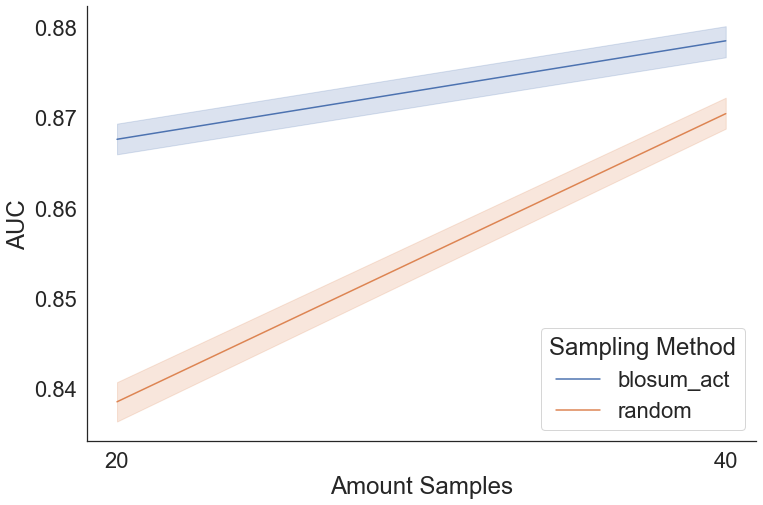

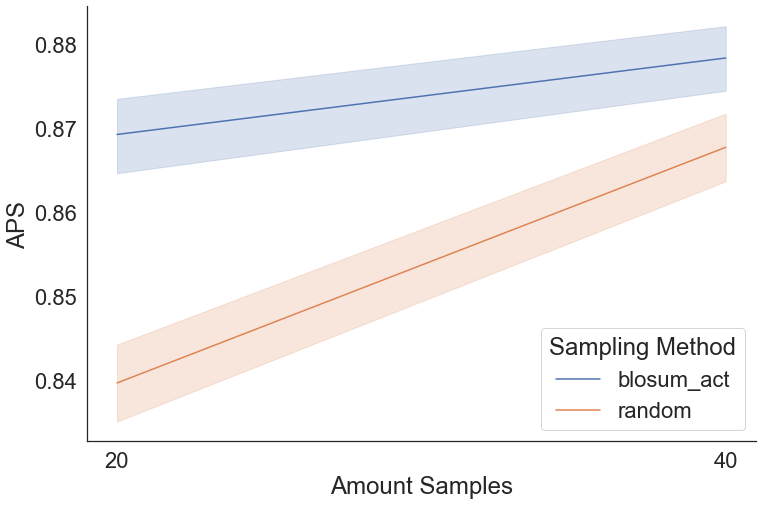

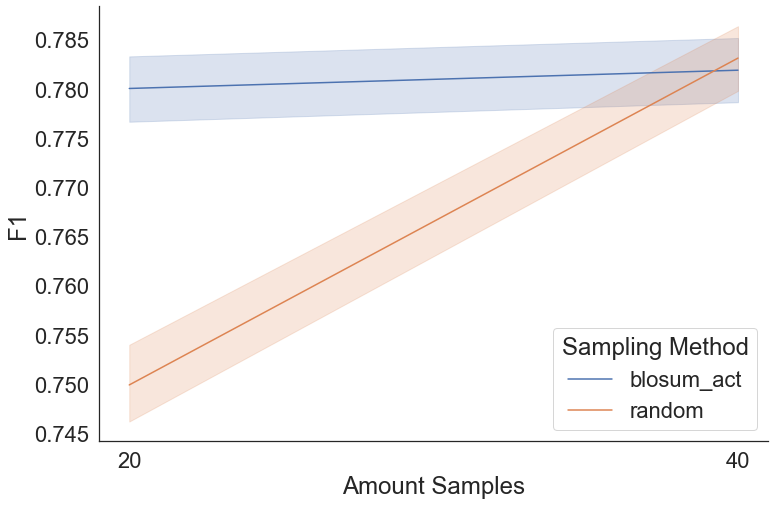

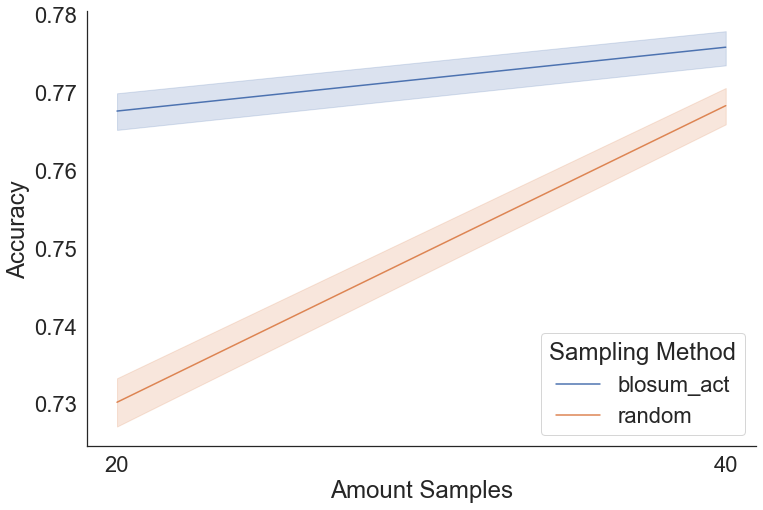

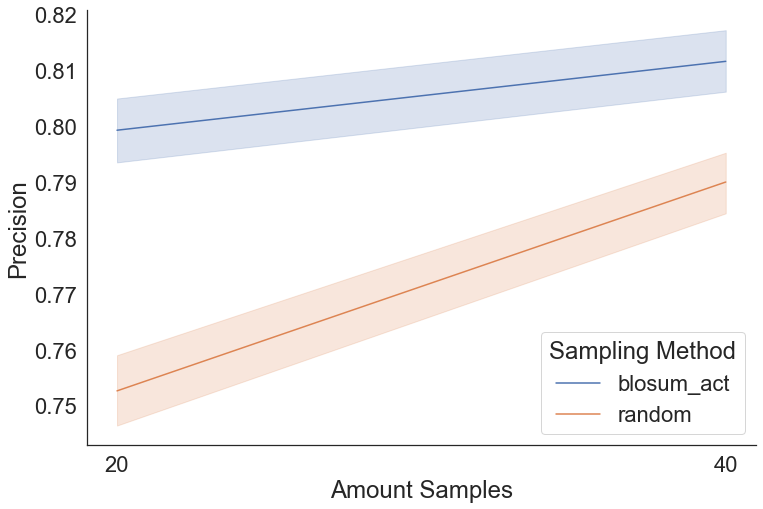

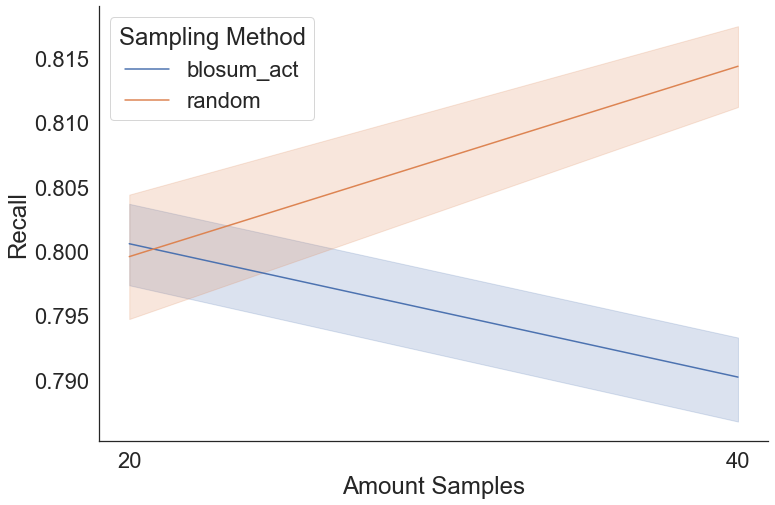

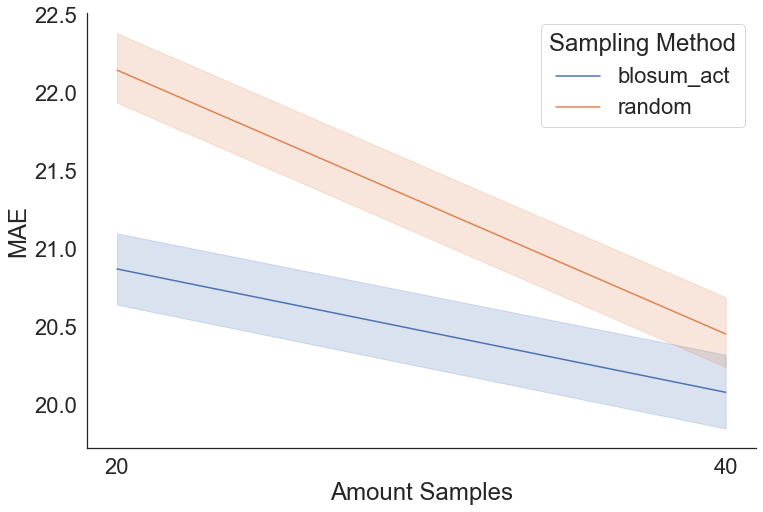

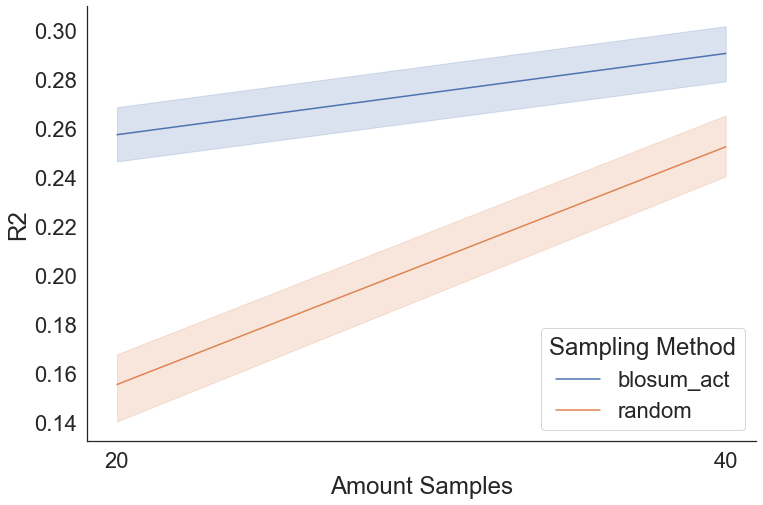

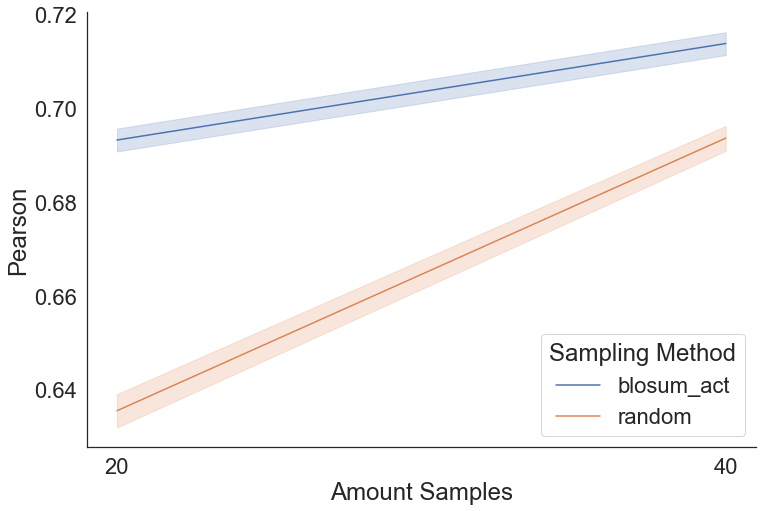

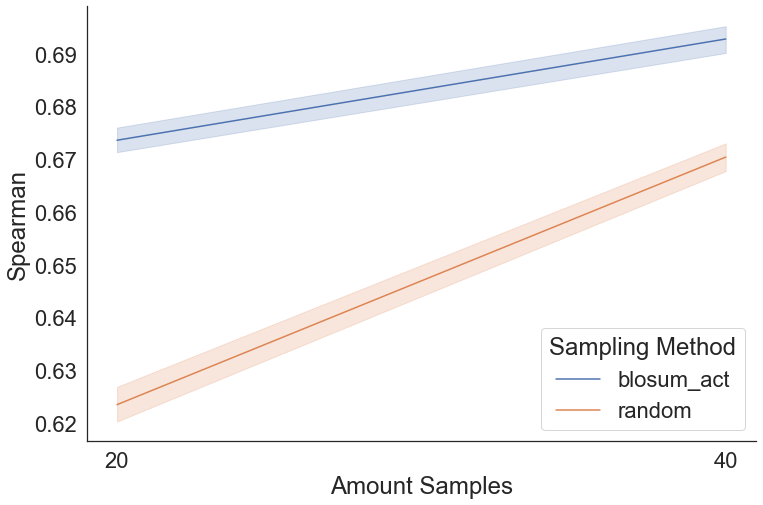

In [29]:
palette = {'active': 'tab:red', 'upper': 'tab:olive', 'random': 'tab:cyan'}
palette = None
x_ticks = list(range(0, M))
x_labels = [str((i+1)*N) for i in range(M)]

do_plots(summary_full, palette, x_ticks, x_labels, sns.lineplot)

## New Cancer Epitope

In [30]:
BASE_EPITOPE = 'VPSVWRSSL'
random.seed(42)
np.random.seed(42)
init_set = add_blosum_active(data_full, None, [], None, None, 20)
init_set

['GPSVWRSSL',
 'VFSVWRSSL',
 'VPWVWRSSL',
 'VPSDWRSSL',
 'VPSVNRSSL',
 'VPSVWVSSL',
 'VPSVWRWSL',
 'VPSVWRSWL',
 'VPSVWRSSD',
 'VPSVWRSSL',
 'VPYVWRSSL',
 'FPSVWRSSL',
 'VPSVQRSSL',
 'VPSVWRSSF',
 'VPSKWRSSL',
 'VPSVWRSKL',
 'VPSVWRFSL',
 'VTSVWRSSL',
 'VPSVWASSL',
 'VPSVSRSSL']

In [31]:
reasons = ['blosum'] * 9 + ['base'] * 1 + ['rdm_pos'] * 10
df = pd.DataFrame(data={'APL': init_set, 'Reason': reasons})
df.to_csv('../results/humanTcrs_initAPLs.csv')
df

,APL,Reason
0,GPSVWRSSL,blosum
1,VFSVWRSSL,blosum
2,VPWVWRSSL,blosum
3,VPSDWRSSL,blosum
4,VPSVNRSSL,blosum
5,VPSVWVSSL,blosum
6,VPSVWRWSL,blosum
7,VPSVWRSWL,blosum
8,VPSVWRSSD,blosum
9,VPSVWRSSL,base
